In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from utils.initialise_weights import initialise_weights
from src.data_loader import *
from tqdm import tqdm
from utils.plot_to_tensorboard import plot_to_tensorboard
from utils.clear_folder import *
import torchshow as ts
import utils.plot_spectrograms as plot_spectrograms

# autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64,kernel_size=5, stride=1,requires_sum=True,generator=True):
        super(ConvBlock, self).__init__()
        self.requires_sum = requires_sum
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,stride=stride, padding='same' if generator else 2),
            nn.PReLU() if generator else nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,stride=stride, padding='same' if generator else 2) if self.requires_sum else nn.Identity()) # changed in_channels to out_channels 15 Jul 2023 @ 15:39:28
        
    def forward(self, x):
        if self.requires_sum is True:
            out = self.block(x)
            return x + out
        else:
            out = self.block(x)
            return out
        


class ConvBlock1D(nn.Module): # Requires to be rewritten to incooperate the 1DConvolutions
    def __init__(self,in_channels=1, out_channels=64,kernel_size=32, stride=2,padding=0):
        super(ConvBlock1D, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU()
        )

    def forward(self,x):
        return self.block(x)
    


class Generator(nn.Module):
    def __init__(self,in_channel=2, out_channel=64, blocks=4):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel,kernel_size=11,stride=1,padding='same'),
            nn.PReLU()
        )

        self.blocks = nn.Sequential(*[ConvBlock() for _ in range(blocks)])
        self.conv = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,kernel_size=5,stride=1,padding='same')

        self.terminal = nn.Sequential(
            ConvBlock(in_channels=out_channel, out_channels=out_channel,requires_sum=False),
            ConvBlock(in_channels=out_channel, out_channels=out_channel,requires_sum=False),
            nn.Conv2d(in_channels=out_channel, out_channels=3,kernel_size=11,stride=1,padding='same')
        )

    def forward(self, z):
        # https://de.wikipedia.org/wiki/Arctan2
        z = self.initial(z)
        out = self.blocks(z)
        out = self.conv(out)
        out = out + z
        out = self.terminal(out)

        mag  = out[:,:1,:,:]
        phase = torch.arctan2(out[:,1:2,:,:], out[:,2:,:,:]) # requires to be changed 26 Jul 2023 @ 17:09:54
        out = torch.cat([mag, phase],dim=1)
        return out


class Discriminator(nn.Module):
    def __init__(self,in_channels=3,out_channels=32,in_features=2048,out_features=512,in_features_final=2048,blocks=2):
        super(Discriminator, self).__init__()        
        self.magnitude_path = nn.Sequential(
            ConvBlock(in_channels=1,out_channels=out_channels,stride=2,requires_sum=False,generator=False),
            ConvBlock(in_channels=out_channels,out_channels=out_channels,stride=2,requires_sum=False,generator=False),
            ConvBlock(in_channels=out_channels,out_channels=out_channels,stride=2,requires_sum=False,generator=False),
            ConvBlock(in_channels=out_channels,out_channels=out_channels,stride=2,requires_sum=False,generator=False),
            ConvBlock(in_channels=out_channels,out_channels=out_channels,stride=2,requires_sum=False,generator=False))
        
        self.magnitude_linear = nn.Sequential(
            nn.Linear(in_features=32*16*16,out_features=65385),
            nn.LeakyReLU(),
        )
        
        self.phase_path = ConvBlock1D(in_channels=1,out_channels=32)


        # [f(x) if condition else g(x) for x in sequence]
        self.blocks = nn.Sequential(*[ConvBlock1D(in_channels=33, out_channels=64) if block == 0 else ConvBlock1D(in_channels=64, out_channels=64) for block in range(blocks)])

        self.terminal = nn.Sequential(
            nn.Linear(in_features=14400,out_features=1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024,out_features=1)
        )


    def forward(self, phase, magnitude):
        # phase = self.istft_transform(comp)        
        phase = self.phase_path(phase)

        mag = self.magnitude_path(magnitude) # will be 32 * H_mag * W_mag
        mag = mag.view(mag.shape[0],-1)
        mag = self.magnitude_linear(mag).unsqueeze_(1)

        out = torch.cat([mag,phase],dim=1)
        out = self.blocks(out)
        out = out.view(out.shape[0],-1)
        out = self.terminal(out)

        return out.view(out.size(0), 1, 1, -1)


    

    @staticmethod
    def istft_transform(batch):
        def convert_to_complex(mag, angle):
        # https://dsp.stackexchange.com/a/72172 
            return mag*(torch.cos(angle)+1j* torch.sin(angle))
        
        batch_size = batch[0].shape[0]

        signals = []
        for i in range(batch_size):
            complex_spectrogram = convert_to_complex(batch[i][0], batch[i][1])
            new_row = torch.zeros(1, 512)
            complex_spectrogram = torch.cat((complex_spectrogram, new_row), dim=0)
            signal = torch.istft(complex_spectrogram,n_fft=1024,hop_length=512).unsqueeze_(0).unsqueeze_(0)
            signals.append(signal)

        signals = torch.cat(signals, dim=0)
        return signals
        

In [3]:
# Dimensionality Testing
# # Generator Test
# B, C, H, W = 1, 1, 512, 512
# x = torch.randn(B, C, H, W)
# gen = Generator(1, 64, 4)
# assert gen(x).shape == (B,2,H,W)

# # Discriminator Test
# x = torch.randn(B, 2, H, W)
# x2 = torch.randn(B, 1, H, W)
# critic = Discriminator(blocks=4)
# assert critic(x,x2).shape == (B, 1, 1, 1)
# print("Dimensionality Testing Passed")


torch.Size([2, 1, 512, 512])


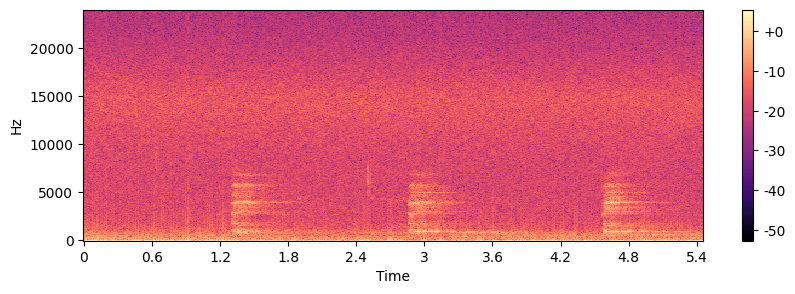

In [4]:
# Real Data Testing
# Data Loader

dataset = 0

if dataset:

    path = '../data/AudioMNIST_Indicies/dummy_labels.csv'
    root_dir = '../data/AudioMNIST/'

else:
    path = '../data/AvianID_AcousticIndices/UK_AI.csv'
    root_dir='../data/UK_BIRD/'

# 

ds = AvianNatureSounds(annotation_file_path=path,
                       root_dir=root_dir,
                       key='habitat',
                       mode='stft',
                       length=5,
                       sampling_rate=44100,
                       n_fft=1024,
                       hop_length=512,
                       mel_spectrogram=None,
                       verbose=False,
                       fixed_limit=True)



train_loader = DataLoader(dataset=ds, batch_size=2, shuffle=True,pin_memory=True)



ground_truth, input_mag, _ = next(iter(train_loader))


print(input_mag.unsqueeze_(1).shape)
# Visual Testing
enable = True
if enable:
    plot_spectrograms.plot_spectrograms(input_mag,magnitude=True)


# Generator Check
# initialise_weights(gen)
# gen = Generator(1, 64, 4)
# fake = gen(input_mag)
# assert fake.shape == ground_truth.shape

# fake.shape
# fake[:,:1,:,:] = phase
# fake[:,1:,:,:] = mag


In [ ]:
# Hyperparameter
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu'

lr = 3e-4
img_sz = 64
channel_img = 1
epochs = 3

In [ ]:
gen = Generator(in_channel=1).to(device)
disc = Discriminator(blocks=4).to(device)

initialise_weights(gen)
initialise_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.MSELoss()

writer_fake = SummaryWriter(f'../data/runs/PhaseGAN/fake')
writer_real = SummaryWriter(f'../data/runs/PhaseGAN/real')
writer = SummaryWriter(f'../data/runs/PhaseGAN/log')
step = 0

gen.train()
disc.train()

In [ ]:
clear_folders('../data/runs/PhaseGAN/fake/','../data/runs/PhaseGAN/real/', '../data/runs/PhaseGAN/log/')

In [ ]:
def convert_to_complex(mag, angle):
    # https://dsp.stackexchange.com/a/72172 
    return mag*(np.cos(angle)+1j* np.sin(angle))


def istft_transform(batch):
    batch_size = batch[0].shape[0]

    signals = []
    for i in range(batch_size):
        complex_spectrogram = convert_to_complex(batch[i][0], batch[i][1])
        new_row = torch.zeros(1, 512)
        complex_spectrogram = torch.cat((complex_spectrogram, new_row), dim=0)
        signal = torch.istft(complex_spectrogram,n_fft=1024,hop_length=512).unsqueeze_(0).unsqueeze_(0)
        signals.append(signal)

    signals = torch.cat(signals, dim=0)
    return signals


device = 'cpu'

mag = torch.randn(512,512).to(device)
phase = torch.randn(512,512).to(device)

convert_to_complex(mag,phase).shape

In [ ]:
def train():
    batch = next(iter(train_loader))

    print('yes')

    real_img, mag, _ = batch

    # writer_fake = SummaryWriter(f'../data/runs/PhaseGAN/fake')
    # writer_real = SummaryWriter(f'../data/runs/PhaseGAN/real')
    # writer = SummaryWriter(f'../data/runs/PhaseGAN/log')
    # step = 0

    for epoch in range(epochs):
        # loop = tqdm(batch, leave=False)
        # for idx, (real_img, mag, _) in enumerate(loop):

        real_img = real_img.to(device)

        print(real_img.shape)

        magnitude = mag.to(device)

        print(magnitude.shape)

        fake = gen(magnitude)

        print(fake.shape)

        ### Signal Reconstruction ###

        fake_signal = istft_transform(fake)
        real_signal = istft_transform(real_img)

        print(fake_signal.shape)


        ### Train Discriminator ###
        disc_real = disc(real_img, magnitude)


        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake, magnitude)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2


        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator ###
        output = disc(fake)
        loss_gen = criterion(output, torch.ones_like(output)) / 2
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # if idx == 0:
        if epoch + 1:
            print(
                f'Epoch [{epoch / epochs}] \  '
                f'Loss D: {loss_disc.item():.4f}, Loss G: {loss_gen.item():.4f}'
            )

        # if idx % 50 == 0:
        #     plot_to_tensorboard(
        #         writer = writer,
        #         loss_critic = loss_disc.item(),
        #         loss_gen = loss_gen.item(),
        #         real = real_img[:,:1,:,:] ,
        #         fake = fake[:,:1,:,:],
        #         tb_step = step,
        #         images = True
        #     )

        #     step += 1
            

            # with torch.no_grad():
            #     fake = gen(fixed_noise).reshape(-1, 1,64,64)
            #     data = real_img.reshape(-1, 1, 64, 64)

            #     img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            #     img_grid_real = torchvision.utils.make_grid(data, normalize=True)

            #     writer_fake.add_image(
            #         'MNIST Fake Images', img_grid_fake, global_step=step
            #     )

            #     writer_real.add_image(
            #         'MNIST Real Images', img_grid_real, global_step=step
            #     )

            #     step += 1